In [12]:
from torch_geometric.nn import GATv2Conv
from torch.nn import ReLU
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F 
import pickle
from sklearn.metrics import roc_curve,auc


if torch.cuda.is_available():
    statedicts=torch.load("DiffPIC_statedict.pth")
else:
    statedicts=torch.load("DiffPIC_statedict.pth",map_location=torch.device('cpu'))

### Model Architecture

In [13]:
class EdgeLabelPredictor(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        ## ESM2 Upper layers
        self.convESM1 = GATv2Conv(1280, 150,heads=3)
        self.convESM2 = GATv2Conv(150*3, 150,heads=3)
        self.convESM3 = GATv2Conv(150*3, 150,heads=3)

        ## Ptotein Abundance Lower layer
        self.convSingle1= GATv2Conv(2, 50,heads=3)
        
        ## MLP layers
        self.fc1=torch.nn.Linear((2*150*3)+(2*50*3), 200)
        self.fc2=torch.nn.Linear(200, 200)
        self.fc3=torch.nn.Linear(200, 1)
        self.relu=ReLU()

    def forward(self, x, edge_index, edge_label_index):
        ## Ignoring final two features which symbolize the mean protein abundances in both conditions 
        x_esm = F.relu(self.convESM1(x[:,:-2], edge_index))
        x_esm = F.relu(self.convESM2(x_esm, edge_index))
        x_esm = F.relu(self.convESM3(x_esm, edge_index))

        ## Only considering protein abundance features
        x_single = F.relu(self.convSingle1(x[:,-2:], edge_index))

        ## Get node embeddings for each edge
        src, dst = edge_label_index

        ## division by 2 since undirected graph (avoid multiple preds on same edge)
        src=src[0:int(len(src)/2)]
        dst=dst[0:int(len(dst)/2)]

        edge_feat_esm = torch.cat((x_esm[src], x_esm[dst]), dim=1)
        edge_feat_single = torch.cat((x_single[src], x_single[dst]), dim=1)

        comb=torch.cat((edge_feat_esm,edge_feat_single),1)

        ## MLP decoder for edge classification
        x=self.fc1(comb)
        x=self.relu(x)
        x=self.fc2(x)
        x=self.relu(x)
        x=self.fc3(x)
        return x.squeeze()

### Load Model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = EdgeLabelPredictor(in_channels=1282, out_channels=1)
model.load_state_dict(statedicts)

Using device: cpu


<All keys matched successfully>

### Test Data Evaluation

In [15]:
tests=[]
tests.append(torch.load("../PyG_Data/Test.pth",weights_only=False))

In [16]:
model.eval()
with torch.no_grad():
    y_pred=[]
    for i in tests:
        out = model(i.x, i.edge_index, i.edge_label_index)
        out=F.sigmoid(out) ## to compute probabilities
        y_pred.extend(out.tolist())
y_pred_labels=[]
for i in y_pred:
    if i >=0.2706645727157593: ## optimal threshold based on validation set
        y_pred_labels.append(1)
    else:
        y_pred_labels.append(0)

y_true=[]
for i in tests:
    y_true.extend(i.edge_labels.tolist())
y_true=y_true[0:int(len(y_true)/2)]

#### Confusion Matrix with Optimal Threshold

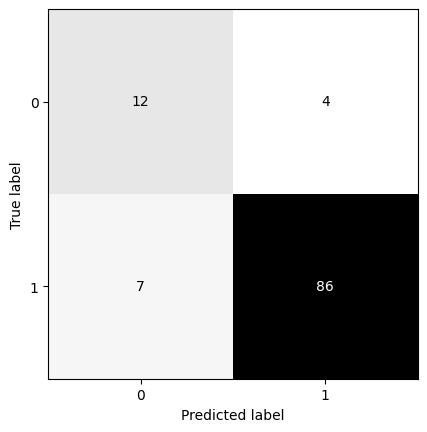

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred_labels, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot(cmap='binary', colorbar=False)

#### ROC-AUC

Text(0, 0.5, 'True Positive Rate')

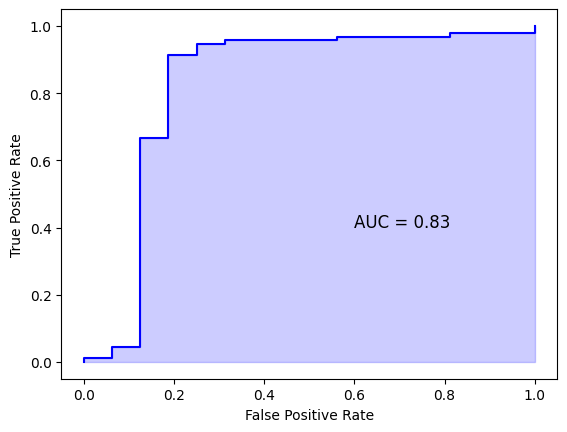

In [18]:
# Get ROC curve values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
## Calculate AUC
roc_auc = auc(fpr, tpr)
## Plot ROC curve
plt.plot(fpr, tpr, color='blue')
plt.text(0.6,0.4,f"AUC = {roc_auc:.2f}",size="large")
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')  # Shade area under curve
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")